In [3]:
import numpy as np
import glob
import scipy.io as sio
import torch
from torch import nn
import random
import csv
import os
from tqdm import tqdm
from torch.utils.data import Dataset, DataLoader
import yaml
from evaluate import error
import time
import re
from syn_DI_dataset import make_dataset, make_dataloader
import matplotlib.pyplot as plt

In [2]:
dataset_root = 'd:\Data\My_MMFi_Data\MMFi_Dataset'
# xian zai shi yong de shi Radar_Fused
with open('config.yaml', 'r') as fd:
    config = yaml.load(fd, Loader=yaml.FullLoader)

train_dataset, val_dataset = make_dataset(dataset_root, config)

['rgb', 'depth', 'lidar', 'mmwave', 'wifi-csi']
S02 ['A01', 'A02', 'A03', 'A04', 'A06', 'A08', 'A09', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A18', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A26']
S03 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A12', 'A15', 'A16', 'A17', 'A18', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27']
S05 ['A01', 'A02', 'A03', 'A04', 'A05', 'A06', 'A07', 'A09', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A16', 'A19', 'A20', 'A21', 'A24', 'A25']
S06 ['A01', 'A03', 'A04', 'A06', 'A07', 'A08', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A18', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27']
S08 ['A01', 'A02', 'A04', 'A05', 'A06', 'A07', 'A08', 'A09', 'A10', 'A11', 'A13', 'A14', 'A17', 'A19', 'A20', 'A21', 'A22', 'A23', 'A24', 'A25', 'A26', 'A27']
S09 ['A01', 'A07', 'A08', 'A10', 'A11', 'A12', 'A13', 'A14', 'A15', 'A17', 'A18', 'A20', 'A21', 'A24', 'A25', 'A27']
S11 ['A01', 'A02', 'A03', 'A05', 'A06', 'A08', 'A10', 'A11', 'A12', 

KeyboardInterrupt: 

In [ ]:
def generate_none_empth_modality_list():
    modality_list = random.choices(
        [True, False],
        k= 5,
        weights=[80, 20]
    )
    if sum(modality_list) == 0:
        modality_list = generate_none_empth_modality_list()
        return modality_list
    else:
        return modality_list


def collate_fn_padd(batch):
    '''
    Padds batch of variable length

    note: it converts things ToTensor manually here since the ToTensor transform
    assume it takes in images rather than arbitrary tensors.

    dict_keys(['modality', 'scene', 'subject', 'action', 'idx', 'output', 
    'input_rgb', 'input_depth', 'input_lidar', 'input_mmwave'])
    '''
    ## get sequence lengths
    # for t in batch:
    #     print(t.keys())
    #     print(a)
    # #     # print(t[0].shape,t[1].shape)
    kpts = []
    [kpts.append(np.array(t['output'])) for t in batch]
    kpts = torch.FloatTensor(np.array(kpts))

    lengths = torch.tensor([t['input_mmwave'].shape[0] for t in batch ])

    # rgb
    rgb_data = np.array([(t['input_rgb']) for t in batch ])
    rgb_data = torch.FloatTensor(rgb_data).permute(0,3,1,2)

    # depth
    depth_data = np.array([(t['input_depth']) for t in batch ])
    depth_data = torch.FloatTensor(depth_data).permute(0,3,1,2)

    # mmwave
    ## padd
    mmwave_data = [torch.Tensor(t['input_mmwave']) for t in batch ]
    mmwave_data = torch.nn.utils.rnn.pad_sequence(mmwave_data)
    ## compute mask
    mmwave_data = mmwave_data.permute(1,0,2)

    # lidar
    ## padd
    lidar_data = [torch.Tensor(t['input_lidar']) for t in batch ]
    lidar_data = torch.nn.utils.rnn.pad_sequence(lidar_data)
    ## compute mask
    lidar_data = lidar_data.permute(1,0,2)

    # wifi-csi
    wifi_data = np.array([(t['input_wifi-csi']) for t in batch ])
    wifi_data = torch.FloatTensor(wifi_data)
    
    modality_list = generate_none_empth_modality_list()

    return rgb_data, depth_data, lidar_data, mmwave_data, wifi_data, kpts, modality_list

In [ ]:
rng_generator = torch.manual_seed(config['init_rand_seed'])
train_loader = make_dataloader(train_dataset, is_training=True, generator=rng_generator, **config['loader'], collate_fn = collate_fn_padd)
val_loader = make_dataloader(val_dataset, is_training=False, generator=rng_generator, **config['loader'], collate_fn = collate_fn_padd)

In [6]:
from MI_model_5_exp import modality_invariant_model
# from MI_model_5_4input import modality_invariant_model
# from MI_model import modality_invariant_model

model = modality_invariant_model()
model.cuda()

modality_invariant_model(
  (feature_extractor): feature_extrator(
    (rgb_extractor): rgb_feature_extractor(
      (part): Sequential(
        (0): Sequential(
          (0): Conv2d(3, 3, kernel_size=(14, 14), stride=(2, 2))
          (1): ReLU()
          (2): Conv2d(3, 3, kernel_size=(5, 56), stride=(1, 1))
          (3): ReLU()
          (4): Conv2d(3, 3, kernel_size=(5, 23), stride=(1, 1))
          (5): ReLU()
          (6): Conv2d(3, 16, kernel_size=(3, 14), stride=(1, 1))
        )
        (1): Conv2d(16, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
        (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (3): ReLU()
        (4): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
        (5): Sequential(
          (0): Block(
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
            (batch_norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1

In [7]:
criterion = nn.CrossEntropyLoss()
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
parameter_dir = './pre-trained_weights/MI_9thApr(2nd).pt'
model.load_state_dict(torch.load(parameter_dir))

<All keys matched successfully>

### selective sample

In [179]:
import scipy.io as scio
import cv2
# rgb_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/rgb/frame144.png"
# depth_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/depth/frame144.png"
# lidar_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/lidar/frame144.bin"
# mmwave_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/mmwave/frame144.bin"
# wifi_csi_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/wifi-csi/frame144.mat"
rgb_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/rgb/frame276.png"
depth_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/depth/frame276.png"
lidar_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/lidar/frame276.bin"
mmwave_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/mmwave/frame276.bin"
wifi_csi_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/wifi-csi/frame276.mat"
gt_dir = "D:/Data/My_MMFi_Data/MMFi_Dataset/E01/S03/A20/ground_truth.npy"

rgb_data = cv2.imread(rgb_dir)

depth_data = cv2.imread(depth_dir)

with open(lidar_dir, 'rb') as f:
    lidar_raw_data = f.read()
    lidar_data = np.frombuffer(lidar_raw_data, dtype=np.float64)
    lidar_data = lidar_data.reshape(-1, 3)
with open(mmwave_dir, 'rb') as f:
    mmwave_raw_data = f.read()
    mmwave_data = np.frombuffer(mmwave_raw_data, dtype=np.float64)
    mmwave_data = mmwave_data.copy().reshape(-1, 5)
                # data = data[:, :3]
wifi_data = scio.loadmat(wifi_csi_dir)['CSIamp']
wifi_data[np.isinf(scio.loadmat(wifi_csi_dir)['CSIamp'])] = np.nan
for i in range(10):  # 32
    temp_col = wifi_data[:, :, i]
    nan_num = np.count_nonzero(temp_col != temp_col)
    if nan_num != 0:
        temp_not_nan_col = temp_col[temp_col == temp_col]
        temp_col[np.isnan(temp_col)] = temp_not_nan_col.mean()
wifi_data = torch.tensor((wifi_data - np.min(wifi_data)) / (np.max(wifi_data) - np.min(wifi_data)))
wifi_data = np.array(wifi_data)

gt_numpy = np.load(gt_dir)
gt_torch = torch.from_numpy(gt_numpy)
gt = gt_torch[275]

In [205]:
print(rgb_data.shape, depth_data.shape, lidar_data.shape, mmwave_data.shape, wifi_data.shape)
rgb_input = torch.FloatTensor(rgb_data).permute(2,0,1).unsqueeze(0).cuda()
depth_input = torch.FloatTensor(depth_data).permute(2,0,1).unsqueeze(0).cuda()
lidar_input = torch.FloatTensor(lidar_data).unsqueeze(0).cuda()
mmwave_input = torch.FloatTensor(mmwave_data).unsqueeze(0).cuda()
wifi_input = torch.FloatTensor(wifi_data).unsqueeze(0).cuda()
print(rgb_input.shape, depth_input.shape, lidar_input.shape, mmwave_input.shape, wifi_input.shape)
modality_list = [False, False, True, False, True]
outputs, feature_list, projected_features, cross_modal_embedding, cross_attention_embedding = model(rgb_input, depth_input, mmwave_input, lidar_input, wifi_input, modality_list)
# print(outputs)
# print(gt)

(480, 640, 3) (480, 640, 3) (1180, 3) (36, 5) (3, 114, 10)
torch.Size([1, 3, 480, 640]) torch.Size([1, 3, 480, 640]) torch.Size([1, 1180, 3]) torch.Size([1, 36, 5]) torch.Size([1, 3, 114, 10])


In [206]:
np.save('C:/Users/Chen_Xinyan/Desktop/Modality_Invariant/PICs/E01_S03_A20_frame275_RW.npy', outputs.detach().cpu().numpy())

In [93]:
print(outputs.shape)

torch.Size([1, 17, 3])


In [121]:
def imshow_keypoints_3d(
    pose_result,
    img=None,
    skeleton=None,
    pose_kpt_color=None,
    pose_link_color=None,
    vis_height=400,
    kpt_score_thr=0.3,
    num_instances=-1,
    *,
    axis_azimuth=70,
    axis_limit=1.7,
    axis_dist=10.0,
    axis_elev=15.0,
):
    """Draw 3D keypoints and links in 3D coordinates.

    Args:
        pose_result (list[dict]): 3D pose results containing:
            - "keypoints_3d" ([K,4]): 3D keypoints
            - "title" (str): Optional. A string to specify the title of the
                visualization of this pose result
        img (str|np.ndarray): Opptional. The image or image path to show input
            image and/or 2D pose. Note that the image should be given in BGR
            channel order.
        skeleton (list of [idx_i,idx_j]): Skeleton described by a list of
            links, each is a pair of joint indices.
        pose_kpt_color (np.ndarray[Nx3]`): Color of N keypoints. If None, do
            not nddraw keypoints.
        pose_link_color (np.array[Mx3]): Color of M links. If None, do not
            draw links.
        vis_height (int): The image height of the visualization. The width
                will be N*vis_height depending on the number of visualized
                items.
        kpt_score_thr (float): Minimum score of keypoints to be shown.
            Default: 0.3.
        num_instances (int): Number of instances to be shown in 3D. If smaller
            than 0, all the instances in the pose_result will be shown.
            Otherwise, pad or truncate the pose_result to a length of
            num_instances.
        axis_azimuth (float): axis azimuth angle for 3D visualizations.
        axis_dist (float): axis distance for 3D visualizations.
        axis_elev (float): axis elevation view angle for 3D visualizations.
        axis_limit (float): The axis limit to visualize 3d pose. The xyz
            range will be set as:
            - x: [x_c - axis_limit/2, x_c + axis_limit/2]
            - y: [y_c - axis_limit/2, y_c + axis_limit/2]
            - z: [0, axis_limit]
            Where x_c, y_c is the mean value of x and y coordinates
        figsize: (float): figure size in inch.
    """

    show_img = img is not None
    if num_instances < 0:
        num_instances = len(pose_result)
    else:
        if len(pose_result) > num_instances:
            pose_result = pose_result[:num_instances]
        elif len(pose_result) < num_instances:
            pose_result += [dict()] * (num_instances - len(pose_result))
    num_axis = num_instances + 1 if show_img else num_instances

    plt.ioff()
    fig = plt.figure(figsize=(vis_height * num_axis * 0.01, vis_height * 0.01))

    if show_img:
        img = cv2.imread(img) if isinstance(img, str) else img
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (int(vis_height * img.shape[1] / img.shape[0]), vis_height))
        # img = mmcv.imread(img, channel_order='bgr')
        # img = mmcv.bgr2rgb(img)
        # img = mmcv.imrescale(img, scale=vis_height / img.shape[0])

        ax_img = fig.add_subplot(1, num_axis, 1)
        ax_img.get_xaxis().set_visible(False)
        ax_img.get_yaxis().set_visible(False)
        ax_img.set_axis_off()
        ax_img.set_title('Input')
        ax_img.imshow(img, aspect='equal')

    for idx, res in enumerate(pose_result):
        print(res.shape)
        dummy = len(res) == 0
        kpts = np.zeros((1, 3)) if dummy else res.reshape(-1, 4)
        if kpts.shape[1] == 3:
            kpts = np.concatenate([kpts, np.ones((kpts.shape[0], 1))], axis=1)
        valid = kpts[:, 3] >= kpt_score_thr

        ax_idx = idx + 2 if show_img else idx + 1
        ax = fig.add_subplot(1, num_axis, ax_idx, projection='3d')
        ax.view_init(
            elev=axis_elev,
            azim=axis_azimuth,
        )
        x_c = np.mean(kpts[valid, 0]) if sum(valid) > 0 else 0
        y_c = np.mean(kpts[valid, 1]) if sum(valid) > 0 else 0
        ax.set_xlim3d([x_c - axis_limit / 2, x_c + axis_limit / 2])
        ax.set_ylim3d([y_c - axis_limit / 2, y_c + axis_limit / 2])
        ax.set_zlim3d([0, axis_limit])
        ax.set_aspect('auto')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.dist = axis_dist

        if not dummy and pose_kpt_color is not None:
            pose_kpt_color = np.array(pose_kpt_color)
            assert len(pose_kpt_color) == len(kpts)
            x_3d, y_3d, z_3d = np.split(kpts[:, :3], [1, 2], axis=1)
            # matplotlib uses RGB color in [0, 1] value range
            _color = pose_kpt_color[..., ::-1] / 255.
            ax.scatter(
                x_3d[valid],
                y_3d[valid],
                z_3d[valid],
                marker='o',
                color=_color[valid],
            )

        if not dummy and skeleton is not None and pose_link_color is not None:
            pose_link_color = np.array(pose_link_color)
            assert len(pose_link_color) == len(skeleton)
            for link, link_color in zip(skeleton, pose_link_color):
                link_indices = [_i for _i in link]
                xs_3d = kpts[link_indices, 0]
                ys_3d = kpts[link_indices, 1]
                zs_3d = kpts[link_indices, 2]
                kpt_score = kpts[link_indices, 3]
                if kpt_score.min() > kpt_score_thr:
                    # matplotlib uses RGB color in [0, 1] value range
                    _color = link_color[::-1] / 255.
                    ax.plot(xs_3d, ys_3d, zs_3d, color=_color, zdir='z')

        if 'title' in res:
            ax.set_title(res['title'])

    # convert figure to numpy array
    fig.tight_layout()
    fig.canvas.draw()
    img_w, img_h = fig.canvas.get_width_height()
    img_vis = np.frombuffer(
        fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(img_h, img_w, -1)
    # img_vis = mmcv.rgb2bgr(img_vis)
    # img_vis = cv2.resize(img_vis, (img_w, img_h))
    img_vis = cv2.cvtColor(img_vis, cv2.COLOR_RGB2BGR)


    plt.close(fig)
    # plt.ion()
    

    return img_vis


In [122]:
skeleton = [[15, 13], [13, 11], [16, 14], [14, 12], [11, 12],
            [5, 11], [6, 12], [5, 6], [5, 7], [6, 8], [7, 9],
            [8, 10], [1, 2], [0, 1], [0, 2], [1, 3], [2, 4],
            [3, 5], [4, 6]]

palette = np.array([[255, 128, 0], [255, 153, 51], [255, 178, 102],
                            [230, 230, 0], [255, 153, 255], [153, 204, 255],
                            [255, 102, 255], [255, 51, 255], [102, 178, 255],
                            [51, 153, 255], [255, 153, 153], [255, 102, 102],
                            [255, 51, 51], [153, 255, 153], [102, 255, 102],
                            [51, 255, 51], [0, 255, 0], [0, 0, 255],
                            [255, 0, 0], [255, 255, 255]])

pose_link_color = palette[[
    0, 0, 0, 0, 7, 7, 7, 9, 9, 9, 9, 9, 16, 16, 16, 16, 16, 16, 16
]]
pose_kpt_color = palette[[
    16, 16, 16, 16, 16, 9, 9, 9, 9, 9, 9, 0, 0, 0, 0, 0, 0
]]
kpt_score_thr = 0.3 # 阈值
radius = 7
thickness = 4

fake_score = torch.ones(1,17,1).cuda()
print(outputs.shape)
print(fake_score.shape)
pred_keypoint_add = torch.cat([outputs , fake_score],dim=2)
pred_keypoint_add = pred_keypoint_add.cpu().detach().numpy()
print(pred_keypoint_add.shape)

torch.Size([1, 17, 3])
torch.Size([1, 17, 1])
(1, 17, 4)


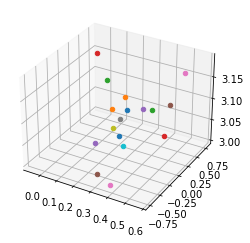

In [170]:
ax = plt.figure().add_subplot(projection='3d')
# for line in skeleton:
#     x = [pred_keypoint_add[0][line[0]][0], pred_keypoint_add[0][line[1]][0]]
#     y = [pred_keypoint_add[0][line[0]][1], pred_keypoint_add[0][line[1]][1]]
#     z = [pred_keypoint_add[0][line[0]][2], pred_keypoint_add[0][line[1]][2]]
#     ax.plot(x, y, z)
#     break
# ax.view_init(elev=-90, azim = 90)
# for i in range(17):
#     ax.scatter(0-pred_keypoint_add[0][i][0], 0-pred_keypoint_add[0][i][1], 0-pred_keypoint_add[0][i][2])
#     # break
# ax.view_init(elev=-90, azim = 90)
for i in range(17):
    ax.scatter(pred_keypoint_add[0][i][0], pred_keypoint_add[0][i][1], pred_keypoint_add[0][i][2])
    # break
plt.show()

In [127]:
img_vis = imshow_keypoints_3d(pred_keypoint_add, img=rgb_dir, skeleton=skeleton, pose_kpt_color=pose_kpt_color, pose_link_color=pose_link_color, kpt_score_thr=kpt_score_thr)

(17, 4)


C:\Users\CHEN_X~1\AppData\Local\Temp/ipykernel_34656/785448849.py:137: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if 'title' in res:


In [128]:
print(img_vis.shape)

(288, 576, 3)


In [129]:
cv2.imwrite('vision.png',img_vis)

True

In [15]:
cv2.imwrite('C:/Users/Chen_Xinyan/Desktop/Modality_Invariant/PICs/rgb_img.jpg',rgb_data)
cv2.imwrite('C:/Users/Chen_Xinyan/Desktop/Modality_Invariant/PICs/depth_img.jpg',depth_data)


True

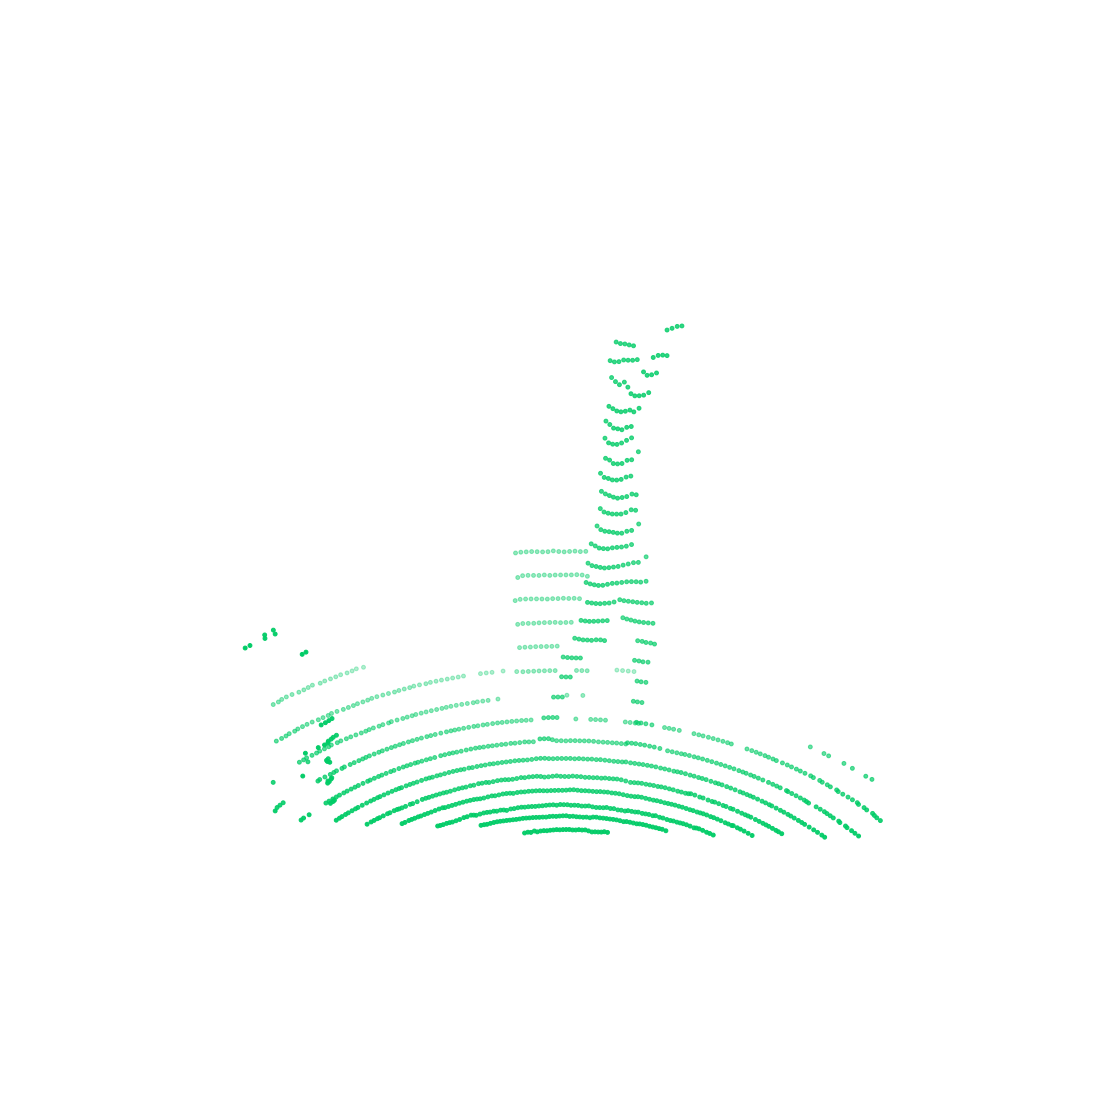

In [60]:
from mpl_toolkits import mplot3d
import numpy as np
import matplotlib.pyplot as plt
 
fig = plt.figure(figsize=(20, 20))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
z = lidar_data[:, 2]
x = lidar_data[:, 0]
y = lidar_data[:, 1]
ax.view_init(elev=15, azim=180)
ax.scatter3D(x, y, z, c = '#00CC66',s=15)
plt.axis('off')
plt.show()
# plt.savefig('C:/Users/Chen_Xinyan/Desktop/Modality_Invariant/PICs/lidar_img.jpg')

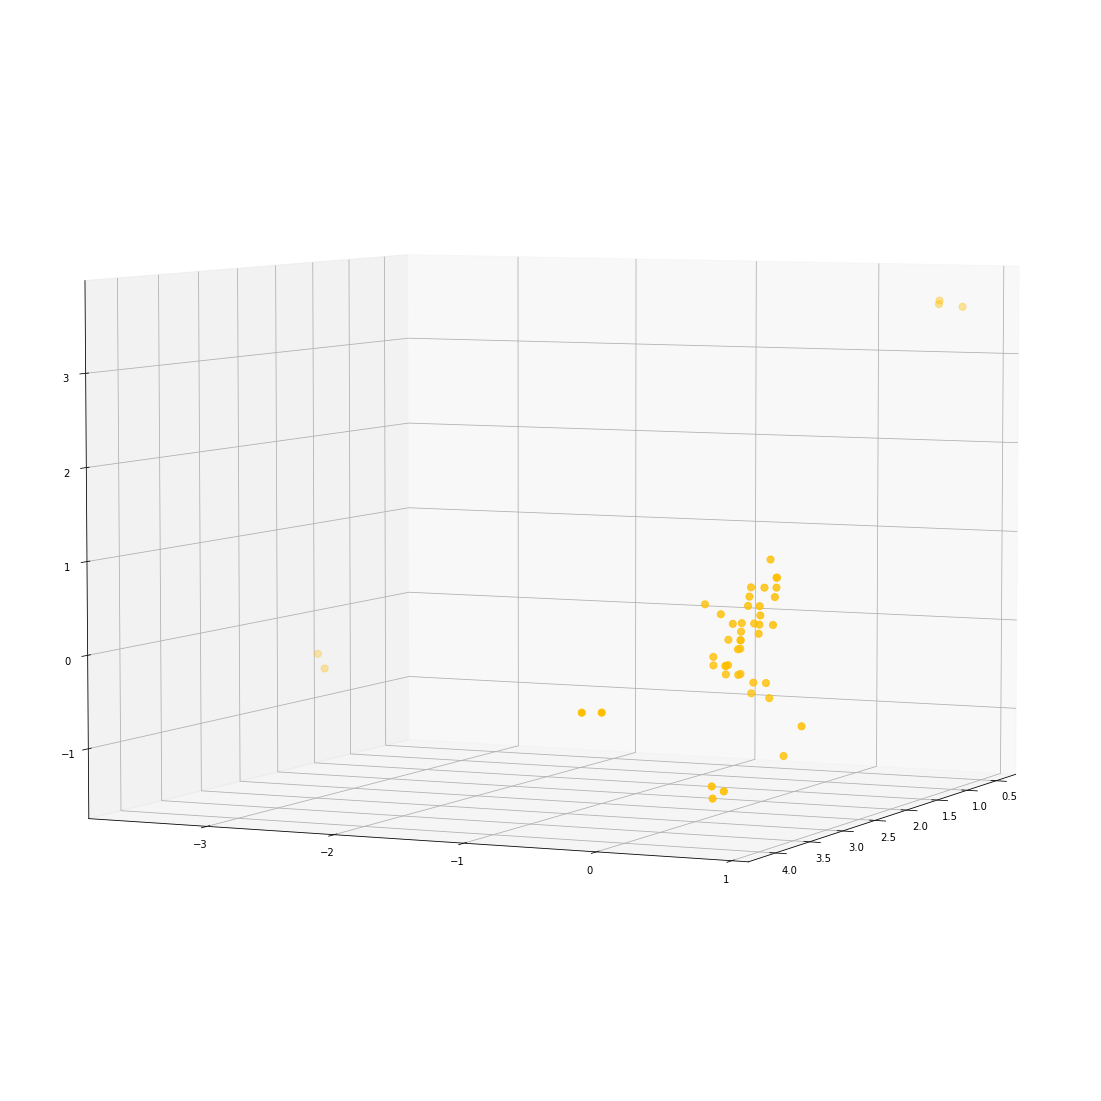

In [70]:
fig = plt.figure(figsize=(20, 20))
 
# syntax for 3-D projection
ax = plt.axes(projection ='3d')
z = mmwave_data[:, 2]
x = mmwave_data[:, 0]
y = mmwave_data[:, 1]
ax.view_init(elev=5, azim=25)
ax.scatter3D(x, y, z, c = '#FFBF00', s=50)
# plt.axis('off')
plt.show()

torch.Size([3, 10, 114])
(30, 114)


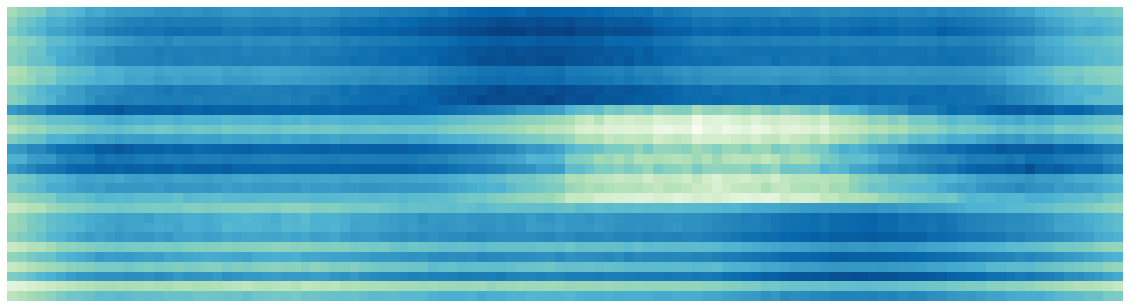

In [90]:
wifi_data_ = torch.FloatTensor(wifi_data).permute(0,2,1)
print(wifi_data_.shape)
wifi_data_ = wifi_data_.reshape(-1,114).numpy()
# wifi_data_ = wifi_data_[2].numpy()
print(wifi_data_.shape)

fig = plt.figure(figsize=(20, 20))
plt.imshow(wifi_data_, cmap='GnBu')
plt.axis('off')
plt.show()

In [16]:
import mmcv
import numpy as np
from matplotlib import pyplot as plt
from mmcv.utils.misc import deprecated_api_warning
from mmcv.visualization.color import color_val
def imshow_keypoints_3d(
    pose_result,
    img=None,
    skeleton=None,
    pose_kpt_color=None,
    pose_link_color=None,
    vis_height=400,
    kpt_score_thr=0.3,
    num_instances=-1,
    *,
    axis_azimuth=70,
    axis_limit=1.7,
    axis_dist=10.0,
    axis_elev=15.0,
):
    """Draw 3D keypoints and links in 3D coordinates.

    Args:
        pose_result (list[dict]): 3D pose results containing:
            - "keypoints_3d" ([K,4]): 3D keypoints
            - "title" (str): Optional. A string to specify the title of the
                visualization of this pose result
        img (str|np.ndarray): Opptional. The image or image path to show input
            image and/or 2D pose. Note that the image should be given in BGR
            channel order.
        skeleton (list of [idx_i,idx_j]): Skeleton described by a list of
            links, each is a pair of joint indices.
        pose_kpt_color (np.ndarray[Nx3]`): Color of N keypoints. If None, do
            not nddraw keypoints.
        pose_link_color (np.array[Mx3]): Color of M links. If None, do not
            draw links.
        vis_height (int): The image height of the visualization. The width
                will be N*vis_height depending on the number of visualized
                items.
        kpt_score_thr (float): Minimum score of keypoints to be shown.
            Default: 0.3.
        num_instances (int): Number of instances to be shown in 3D. If smaller
            than 0, all the instances in the pose_result will be shown.
            Otherwise, pad or truncate the pose_result to a length of
            num_instances.
        axis_azimuth (float): axis azimuth angle for 3D visualizations.
        axis_dist (float): axis distance for 3D visualizations.
        axis_elev (float): axis elevation view angle for 3D visualizations.
        axis_limit (float): The axis limit to visualize 3d pose. The xyz
            range will be set as:
            - x: [x_c - axis_limit/2, x_c + axis_limit/2]
            - y: [y_c - axis_limit/2, y_c + axis_limit/2]
            - z: [0, axis_limit]
            Where x_c, y_c is the mean value of x and y coordinates
        figsize: (float): figure size in inch.
    """

    show_img = img is not None
    if num_instances < 0:
        num_instances = len(pose_result)
    else:
        if len(pose_result) > num_instances:
            pose_result = pose_result[:num_instances]
        elif len(pose_result) < num_instances:
            pose_result += [dict()] * (num_instances - len(pose_result))
    num_axis = num_instances + 1 if show_img else num_instances

    plt.ioff()
    fig = plt.figure(figsize=(vis_height * num_axis * 0.01, vis_height * 0.01))

    if show_img:
        img = mmcv.imread(img, channel_order='bgr')
        img = mmcv.bgr2rgb(img)
        img = mmcv.imrescale(img, scale=vis_height / img.shape[0])

        ax_img = fig.add_subplot(1, num_axis, 1)
        ax_img.get_xaxis().set_visible(False)
        ax_img.get_yaxis().set_visible(False)
        ax_img.set_axis_off()
        ax_img.set_title('Input')
        ax_img.imshow(img, aspect='equal')

    for idx, res in enumerate(pose_result):
        dummy = len(res) == 0
        kpts = np.zeros((1, 3)) if dummy else res['keypoints_3d']
        if kpts.shape[1] == 3:
            kpts = np.concatenate([kpts, np.ones((kpts.shape[0], 1))], axis=1)
        valid = kpts[:, 3] >= kpt_score_thr

        ax_idx = idx + 2 if show_img else idx + 1
        ax = fig.add_subplot(1, num_axis, ax_idx, projection='3d')
        ax.view_init(
            elev=axis_elev,
            azim=axis_azimuth,
        )
        x_c = np.mean(kpts[valid, 0]) if sum(valid) > 0 else 0
        y_c = np.mean(kpts[valid, 1]) if sum(valid) > 0 else 0
        ax.set_xlim3d([x_c - axis_limit / 2, x_c + axis_limit / 2])
        ax.set_ylim3d([y_c - axis_limit / 2, y_c + axis_limit / 2])
        ax.set_zlim3d([0, axis_limit])
        ax.set_aspect('auto')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_zticklabels([])
        ax.dist = axis_dist

        if not dummy and pose_kpt_color is not None:
            pose_kpt_color = np.array(pose_kpt_color)
            assert len(pose_kpt_color) == len(kpts)
            x_3d, y_3d, z_3d = np.split(kpts[:, :3], [1, 2], axis=1)
            # matplotlib uses RGB color in [0, 1] value range
            _color = pose_kpt_color[..., ::-1] / 255.
            ax.scatter(
                x_3d[valid],
                y_3d[valid],
                z_3d[valid],
                marker='o',
                color=_color[valid],
            )

        if not dummy and skeleton is not None and pose_link_color is not None:
            pose_link_color = np.array(pose_link_color)
            assert len(pose_link_color) == len(skeleton)
            for link, link_color in zip(skeleton, pose_link_color):
                link_indices = [_i for _i in link]
                xs_3d = kpts[link_indices, 0]
                ys_3d = kpts[link_indices, 1]
                zs_3d = kpts[link_indices, 2]
                kpt_score = kpts[link_indices, 3]
                if kpt_score.min() > kpt_score_thr:
                    # matplotlib uses RGB color in [0, 1] value range
                    _color = link_color[::-1] / 255.
                    ax.plot(xs_3d, ys_3d, zs_3d, color=_color, zdir='z')

        if 'title' in res:
            ax.set_title(res['title'])

    # convert figure to numpy array
    fig.tight_layout()
    fig.canvas.draw()
    img_w, img_h = fig.canvas.get_width_height()
    img_vis = np.frombuffer(
        fig.canvas.tostring_rgb(), dtype=np.uint8).reshape(img_h, img_w, -1)
    img_vis = mmcv.rgb2bgr(img_vis)

    plt.close(fig)

    return img_vis

ModuleNotFoundError: No module named 'mmcv'

torch.Size([1, 32, 512])
(16, 32)


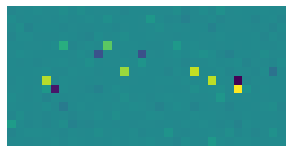

In [12]:
out_attention = cross_modal_embedding['layer4']
print(out_attention.shape)
# pool = nn.AvgPool1d(2)
out_attention = out_attention.squeeze(0).mean(0).reshape(16,32).detach().cpu().numpy()
print(out_attention.shape)
plt.figure(figsize=(5, 5))
plt.imshow(out_attention)
plt.axis('off')
plt.show()

### Random sample

In [52]:
for i, data in tqdm(enumerate(val_loader)):
    start_time = time.time()
    modality_list = [True, True, True, True,True]
    rgb_data, depth_data, lidar_data, mmwave_data, wifi_data, kpts, _ = data
    print(rgb_data.shape, depth_data.shape, lidar_data.shape, mmwave_data.shape, wifi_data.shape)
    # t1 = time.time()
    # load_time = t1 - start_time 
    rgb_data = rgb_data.to(device)
    depth_data = depth_data.to(device)
    lidar_data = lidar_data.to(device)
    mmwave_data = mmwave_data.to(device)
    wifi_data = wifi_data.to(device)
    kpts.to(device)
    labels = kpts.type(torch.FloatTensor)
    outputs, feature_list, projected_features, cross_modal_embedding, cross_attention_embedding = model(rgb_data, depth_data,  mmwave_data, lidar_data,wifi_data, modality_list)
    outputs = outputs.type(torch.FloatTensor)
    if i == 0:
        break

0it [00:00, ?it/s]

torch.Size([16, 3, 480, 640]) torch.Size([16, 3, 480, 640]) torch.Size([16, 1135, 3]) torch.Size([16, 25, 5]) torch.Size([16, 3, 114, 10])


c:\Users\Chen_Xinyan\anaconda3\envs\pytorch\lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
0it [00:00, ?it/s]


In [11]:
print(kpts)

tensor([[[-6.4149e-03, -1.2638e-02,  3.0945e+00],
         [-1.0204e-01, -4.3321e-02,  3.1196e+00],
         [-1.8738e-01,  3.1525e-01,  3.0274e+00],
         [-1.4004e-01,  6.6202e-01,  3.1783e+00],
         [ 8.9207e-02,  1.8046e-02,  3.0693e+00],
         [ 6.1756e-02,  3.9432e-01,  3.1109e+00],
         [ 1.3768e-02,  7.6943e-01,  3.1524e+00],
         [ 9.2919e-03, -2.9483e-01,  3.1145e+00],
         [ 2.4999e-02, -5.7702e-01,  3.1345e+00],
         [ 4.9090e-02, -7.0195e-01,  3.1145e+00],
         [ 4.4151e-02, -7.8195e-01,  3.1445e+00],
         [ 1.3921e-01, -4.9227e-01,  3.1445e+00],
         [ 2.2213e-01, -2.6181e-01,  3.1933e+00],
         [ 7.2464e-02, -3.9521e-01,  3.0428e+00],
         [-1.1330e-01, -5.3683e-01,  3.1445e+00],
         [-2.0931e-01, -3.1030e-01,  3.1945e+00],
         [-2.1149e-02, -3.8233e-01,  3.0437e+00]],

        [[-9.0796e-03, -3.8880e-03,  3.1503e+00],
         [-1.0579e-01, -2.7703e-02,  3.1771e+00],
         [-1.5451e-01,  3.2698e-01,  3.0559e+00]

In [16]:
print(len(feature_list))
print(projected_features.shape)

5
torch.Size([16, 160, 512])


In [18]:
def show_image(image):
    img = np.asarray(image)
    plt.figure(figsize=(5, 5))
    plt.imshow(image)
    plt.axis('off')
    plt.show()


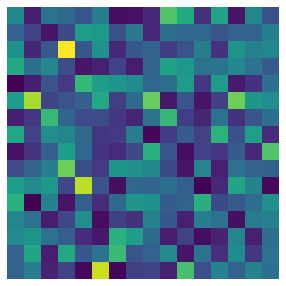

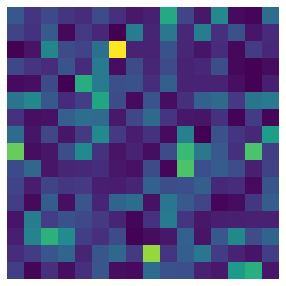

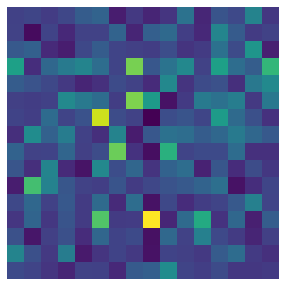

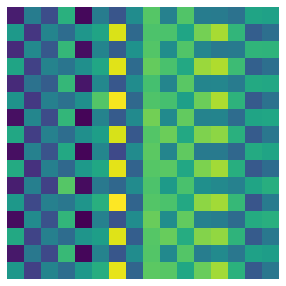

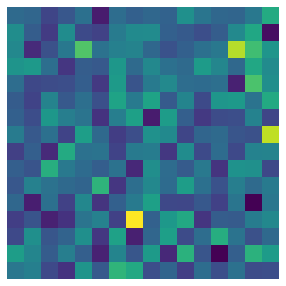

In [19]:
rgb_feature = feature_list[0]
depth_feature = feature_list[1]
mmwave_feature = feature_list[2]
lidar_feature = feature_list[3]
wifi_feature = feature_list[4]

pool = nn.AdaptiveAvgPool1d(256)

rgb_sample = torch.mean(torch.mean(pool(rgb_feature), dim=0), dim=0).reshape(16,16)
depth_sample = torch.mean(torch.mean(pool(depth_feature), dim=0), dim=0).reshape(16,16)
mmwave_sample = torch.mean(torch.mean(pool(mmwave_feature), dim=0), dim=0).reshape(16,16)
lidar_sample = torch.mean(torch.mean(pool(lidar_feature), dim=0), dim=0).reshape(16,16)
wifi_sample = torch.mean(torch.mean(pool(wifi_feature), dim=0), dim=0).reshape(16,16)

show_image(rgb_sample.detach().cpu())
show_image(depth_sample.detach().cpu())
show_image(mmwave_sample.detach().cpu())
show_image(lidar_sample.detach().cpu())
show_image(wifi_sample.detach().cpu())

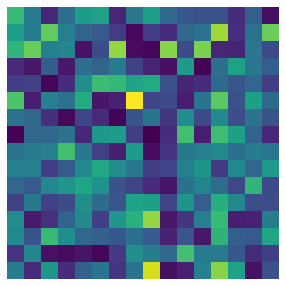

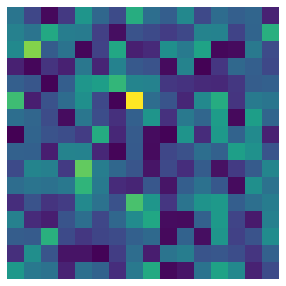

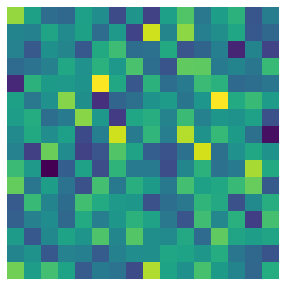

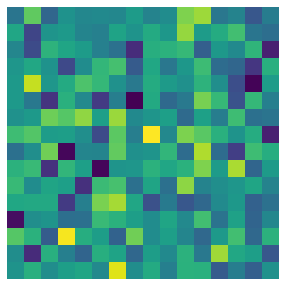

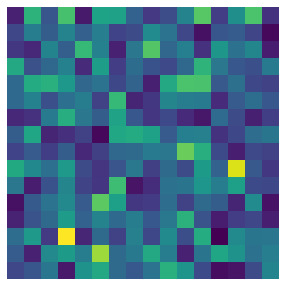

In [20]:
# out, feature_list, projected_features, cross_modal_embedding, cross_attention_embedding
projected_features_list = list(projected_features.chunk(5, dim = 1))
rgb_projected = projected_features_list[0]
depth_projected = projected_features_list[1]
mmwave_projected = projected_features_list[2]
lidar_projected = projected_features_list[3]
wifi_projected = projected_features_list[4]

pool = nn.AdaptiveAvgPool1d(256)

# rgb_projected_sample = rgb_projected[0]
# depth_projected_sample = depth_projected[0]
# lidar_projected_sample = lidar_projected[0]
# mmwave_projected_sample = mmwave_projected[0]
# rgb_projected_sample = pool(torch.mean(rgb_projected, dim=0))
# depth_projected_sample = pool(torch.mean(depth_projected, dim=0))
# lidar_projected_sample = pool(torch.mean(lidar_projected, dim=0))
# mmwave_projected_sample = pool(torch.mean(mmwave_projected, dim=0))
rgb_projected_sample = torch.mean(pool(torch.mean(rgb_projected, dim=0)), dim=0).reshape(16,16)
depth_projected_sample = torch.mean(pool(torch.mean(depth_projected, dim=0)), dim=0).reshape(16,16)
lidar_projected_sample = torch.mean(pool(torch.mean(lidar_projected, dim=0)), dim=0).reshape(16,16)
mmwave_projected_sample = torch.mean(pool(torch.mean(mmwave_projected, dim=0)), dim=0).reshape(16,16)
wifi_projected_sample = torch.mean(pool(torch.mean(wifi_projected, dim=0)), dim=0).reshape(16,16)


show_image(rgb_projected_sample.detach().cpu())
show_image(depth_projected_sample.detach().cpu())
show_image(mmwave_projected_sample.detach().cpu())
show_image(lidar_projected_sample.detach().cpu())
show_image(wifi_projected_sample.detach().cpu())

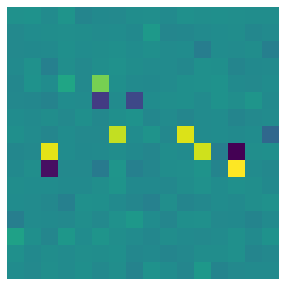

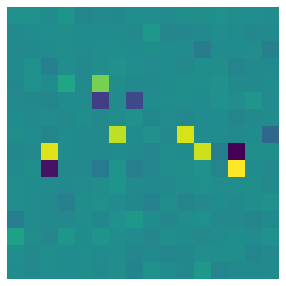

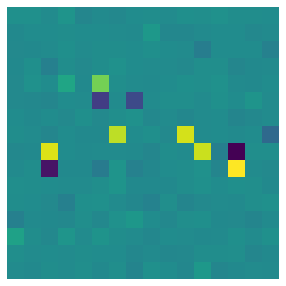

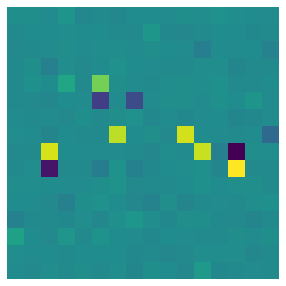

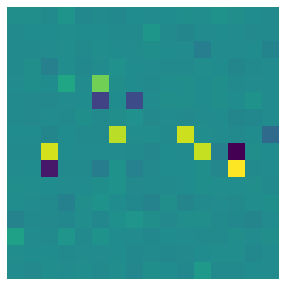

In [21]:
# print(cross_modal_embedding.shape)
cross_modal_embedding_layer_0 = cross_modal_embedding["layer0"]
cross_modal_embedding_layer_1 = cross_modal_embedding["layer1"]
cross_modal_embedding_layer_2 = cross_modal_embedding["layer2"]
cross_modal_embedding_layer_3 = cross_modal_embedding["layer3"]
cross_modal_embedding_layer_4 = cross_modal_embedding["layer4"]

pool = nn.AdaptiveAvgPool1d(256)

# cross_modal_embedding_0_sample = pool(torch.mean(cross_modal_embedding_layer_0, dim=0))
# cross_modal_embedding_1_sample = pool(torch.mean(cross_modal_embedding_layer_1, dim=0))
# cross_modal_embedding_2_sample = pool(torch.mean(cross_modal_embedding_layer_2, dim=0))
# cross_modal_embedding_3_sample = pool(torch.mean(cross_modal_embedding_layer_3, dim=0))
cross_modal_embedding_0_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_0, dim=0)), dim=0).reshape(16,16)
cross_modal_embedding_1_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_1, dim=0)), dim=0).reshape(16,16)
cross_modal_embedding_2_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_2, dim=0)), dim=0).reshape(16,16)
cross_modal_embedding_3_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_3, dim=0)), dim=0).reshape(16,16)
cross_modal_embedding_4_sample = torch.mean(pool(torch.mean(cross_modal_embedding_layer_4, dim=0)), dim=0).reshape(16,16)

show_image(cross_modal_embedding_0_sample.detach().cpu())
show_image(cross_modal_embedding_1_sample.detach().cpu())
show_image(cross_modal_embedding_2_sample.detach().cpu())
show_image(cross_modal_embedding_3_sample.detach().cpu())
show_image(cross_modal_embedding_4_sample.detach().cpu())

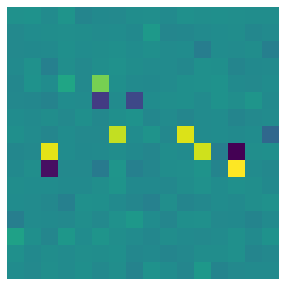

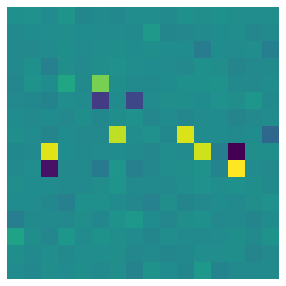

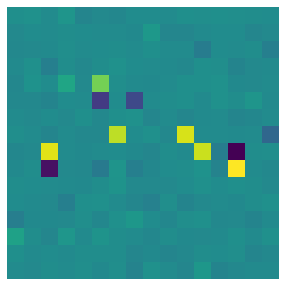

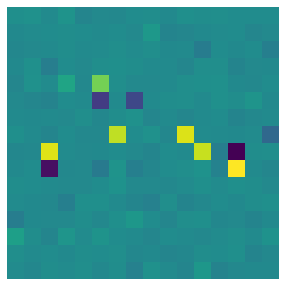

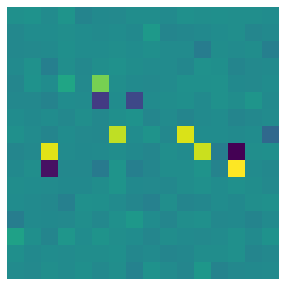

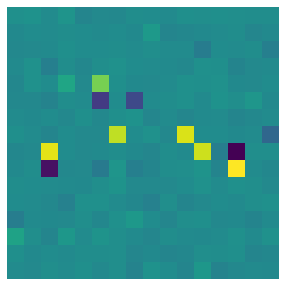

In [22]:
cross_attention_embedding_layer_0 = cross_attention_embedding["layer1"]
# cross_attention_embedding_layer_1 = cross_attention_embedding["layer1"]
# cross_attention_embedding_layer_2 = cross_attention_embedding["layer2"]

modal_features_list = list(cross_attention_embedding_layer_0.chunk(5, dim = 1))
rgb_injected = modal_features_list[0]
depth_injected = modal_features_list[1]
mmwave_injected = modal_features_list[2]
lidar_injected = modal_features_list[3]
wifi_injected = modal_features_list[4]

pool = nn.AdaptiveAvgPool1d(256)

# rgb_injected_sample = rgb_injected[0]
# depth_injected_sample = depth_injected[0]
# lidar_injected_sample = lidar_injected[0]
# mmwave_injected_sample = mmwave_injected[0]
# rgb_injected_sample = pool(torch.mean(rgb_injected, dim=0))
# depth_injected_sample = pool(torch.mean(depth_injected, dim=0))
# lidar_injected_sample = pool(torch.mean(lidar_injected, dim=0))
# mmwave_injected_sample = pool(torch.mean(mmwave_injected, dim=0))
rgb_injected_sample_0 = torch.mean(pool(torch.mean(rgb_injected, dim=0)), dim=0).reshape(16,16)
depth_injected_sample_0 = torch.mean(pool(torch.mean(depth_injected, dim=0)), dim=0).reshape(16,16)
lidar_injected_sample_0 = torch.mean(pool(torch.mean(lidar_injected, dim=0)), dim=0).reshape(16,16)
mmwave_injected_sample_0 = torch.mean(pool(torch.mean(mmwave_injected, dim=0)), dim=0).reshape(16,16)
wifi_injected_sample_0 = torch.mean(pool(torch.mean(wifi_injected, dim=0)), dim=0).reshape(16,16)

# show_image2(rgb_sample.detach().cpu(), rgb_injected_sample.detach().cpu())
show_image(cross_modal_embedding_0_sample.detach().cpu())
show_image(rgb_injected_sample_0.detach().cpu())
show_image(depth_injected_sample_0.detach().cpu())
show_image(mmwave_injected_sample_0.detach().cpu())
show_image(lidar_injected_sample_0.detach().cpu())
show_image(wifi_injected_sample_0.detach().cpu())

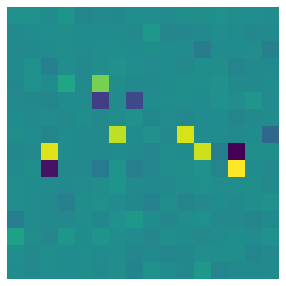

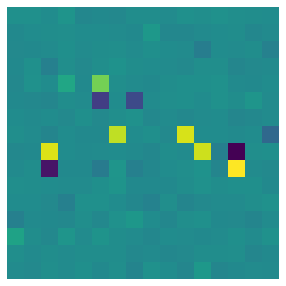

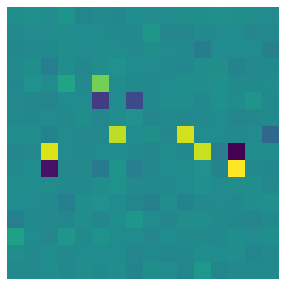

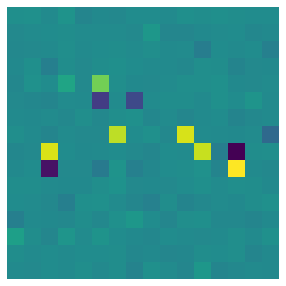

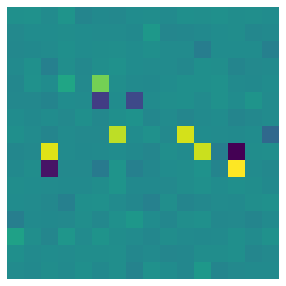

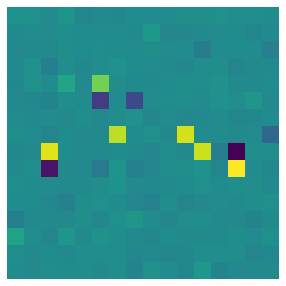

In [24]:
cross_attention_embedding_layer_1 = cross_attention_embedding["layer2"]

modal_features_list = list(cross_attention_embedding_layer_1.chunk(5, dim = 1))
rgb_injected = modal_features_list[0]
depth_injected = modal_features_list[1]
mmwave_injected = modal_features_list[2]
lidar_injected = modal_features_list[3]
wifi_injected = modal_features_list[4]

# rgb_injected_sample = pool(torch.mean(rgb_injected, dim=0))
# depth_injected_sample = pool(torch.mean(depth_injected, dim=0))
# lidar_injected_sample = pool(torch.mean(lidar_injected, dim=0))
# mmwave_injected_sample = pool(torch.mean(mmwave_injected, dim=0))

rgb_injected_sample_1 = torch.mean(pool(torch.mean(rgb_injected, dim=0)), dim=0).reshape(16,16)
depth_injected_sample_1 = torch.mean(pool(torch.mean(depth_injected, dim=0)), dim=0).reshape(16,16)
lidar_injected_sample_1 = torch.mean(pool(torch.mean(lidar_injected, dim=0)), dim=0).reshape(16,16)
mmwave_injected_sample_1 = torch.mean(pool(torch.mean(mmwave_injected, dim=0)), dim=0).reshape(16,16)
wifi_injected_sample_1 = torch.mean(pool(torch.mean(wifi_injected, dim=0)), dim=0).reshape(16,16)

show_image(cross_modal_embedding_1_sample.detach().cpu())
show_image(rgb_injected_sample_1.detach().cpu())
show_image(depth_injected_sample_1.detach().cpu())
show_image(mmwave_injected_sample_1.detach().cpu())
show_image(lidar_injected_sample_1.detach().cpu())
show_image(wifi_injected_sample_1.detach().cpu())

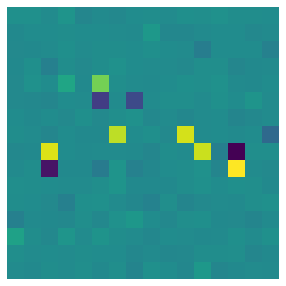

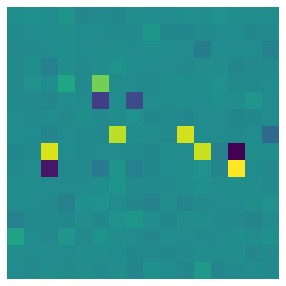

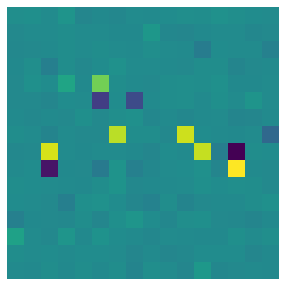

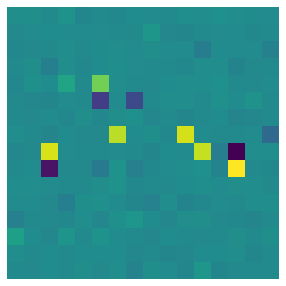

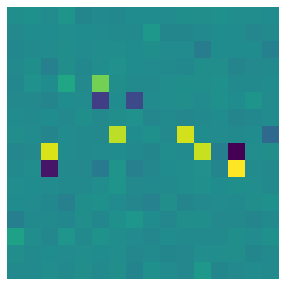

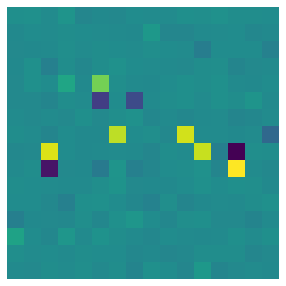

In [25]:
cross_attention_embedding_layer_2 = cross_attention_embedding["layer3"]

modal_features_list = list(cross_attention_embedding_layer_2.chunk(5, dim = 1))
rgb_injected = modal_features_list[0]
depth_injected = modal_features_list[1]
mmwave_injected = modal_features_list[2]
lidar_injected = modal_features_list[3]
wifi_injected = modal_features_list[4]

# rgb_injected_sample = pool(torch.mean(rgb_injected, dim=0))
# depth_injected_sample = pool(torch.mean(depth_injected, dim=0))
# lidar_injected_sample = pool(torch.mean(lidar_injected, dim=0))
# mmwave_injected_sample = pool(torch.mean(mmwave_injected, dim=0))

rgb_injected_sample_2 = torch.mean(pool(torch.mean(rgb_injected, dim=0)), dim=0).reshape(16,16)
depth_injected_sample_2 = torch.mean(pool(torch.mean(depth_injected, dim=0)), dim=0).reshape(16,16)
lidar_injected_sample_2 = torch.mean(pool(torch.mean(lidar_injected, dim=0)), dim=0).reshape(16,16)
mmwave_injected_sample_2 = torch.mean(pool(torch.mean(mmwave_injected, dim=0)), dim=0).reshape(16,16)
wifi_injected_sample_2 = torch.mean(pool(torch.mean(wifi_injected, dim=0)), dim=0).reshape(16,16)

show_image(cross_modal_embedding_2_sample.detach().cpu())
show_image(rgb_injected_sample_2.detach().cpu())
show_image(depth_injected_sample_2.detach().cpu())
show_image(mmwave_injected_sample_2.detach().cpu())
show_image(lidar_injected_sample_2.detach().cpu())
show_image(wifi_injected_sample_2.detach().cpu())

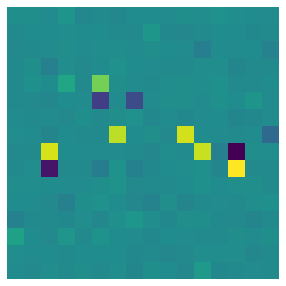

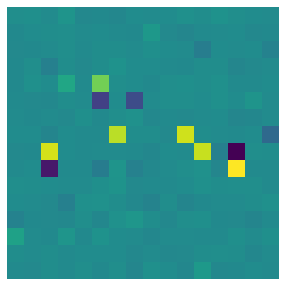

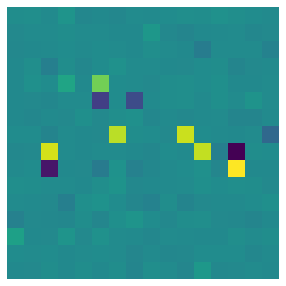

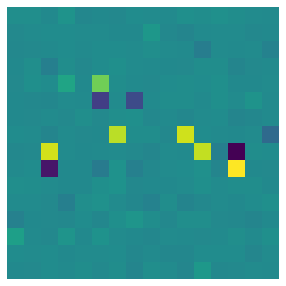

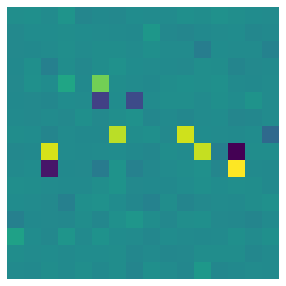

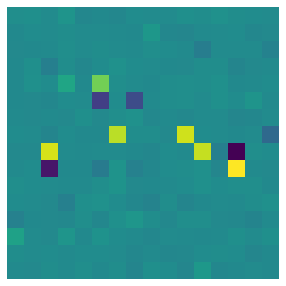

In [26]:
cross_attention_embedding_layer_3 = cross_attention_embedding["layer4"]

modal_features_list = list(cross_attention_embedding_layer_3.chunk(5, dim = 1))
rgb_injected = modal_features_list[0]
depth_injected = modal_features_list[1]
mmwave_injected = modal_features_list[2]
lidar_injected = modal_features_list[3]
wifi_injected = modal_features_list[4]

rgb_injected_sample_3 = torch.mean(pool(torch.mean(rgb_injected, dim=0)), dim=0).reshape(16,16)
depth_injected_sample_3 = torch.mean(pool(torch.mean(depth_injected, dim=0)), dim=0).reshape(16,16)
lidar_injected_sample_3 = torch.mean(pool(torch.mean(lidar_injected, dim=0)), dim=0).reshape(16,16)
mmwave_injected_sample_3 = torch.mean(pool(torch.mean(mmwave_injected, dim=0)), dim=0).reshape(16,16)
wifi_injected_sample_3 = torch.mean(pool(torch.mean(wifi_injected, dim=0)), dim=0).reshape(16,16)

show_image(cross_modal_embedding_3_sample.detach().cpu())
show_image(rgb_injected_sample_3.detach().cpu())
show_image(depth_injected_sample_3.detach().cpu())
show_image(mmwave_injected_sample_3.detach().cpu())
show_image(lidar_injected_sample_3.detach().cpu())
show_image(wifi_injected_sample_3.detach().cpu())


In [38]:
print(cross_attention_embedding.keys())
print(cross_modal_embedding.keys())

dict_keys(['layer1', 'layer2', 'layer3', 'layer4'])
dict_keys(['layer0', 'layer1', 'layer2', 'layer3', 'layer4'])


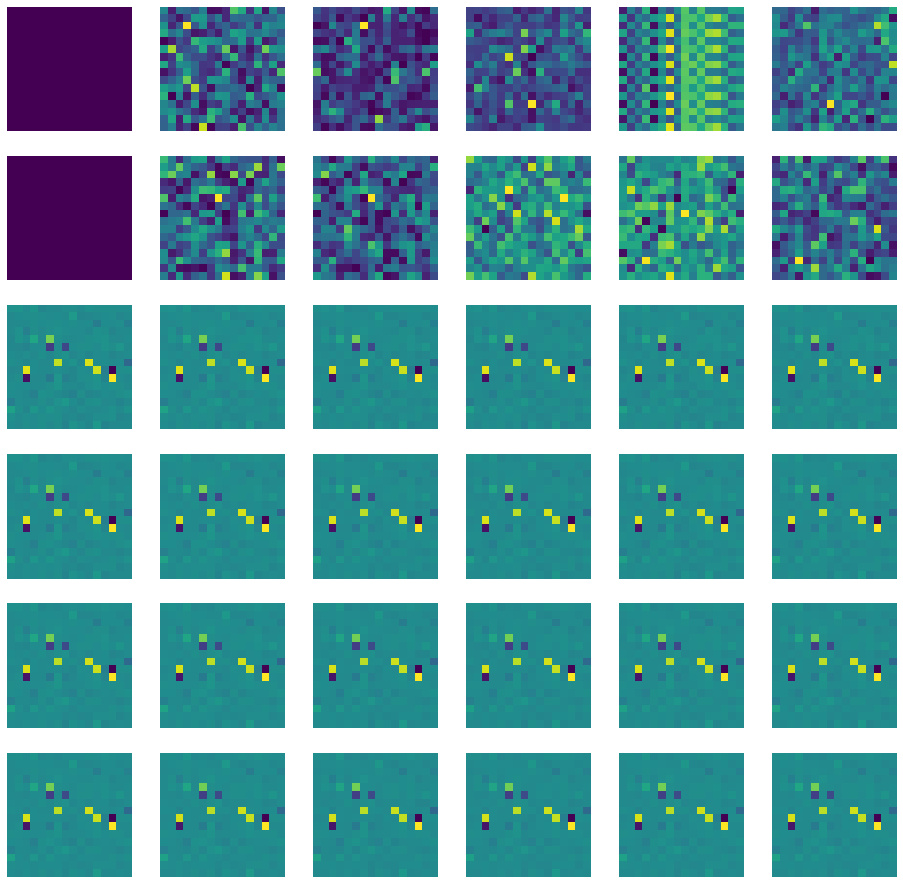

In [27]:
fig = plt.figure(figsize=(16, 16))
fig.add_subplot(6, 6, 1)
blank = np.zeros((16,16))
plt.imshow(blank)
plt.axis('off')
fig.add_subplot(6, 6, 2)
plt.imshow(rgb_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 3)
plt.imshow(depth_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 4)
plt.imshow(mmwave_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 5)
plt.imshow(lidar_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 6)
plt.imshow(wifi_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 7)
plt.imshow(blank)
plt.axis('off')
fig.add_subplot(6, 6, 8)
plt.imshow(rgb_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 9)
plt.imshow(depth_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 10)
plt.imshow(mmwave_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 11)
plt.imshow(lidar_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 12)
plt.imshow(wifi_projected_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 13)
plt.imshow(cross_modal_embedding_0_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 14)
plt.imshow(rgb_injected_sample_0.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 15)
plt.imshow(depth_injected_sample_0.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 16)
plt.imshow(mmwave_injected_sample_0.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 17)
plt.imshow(lidar_injected_sample_0.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 18)
plt.imshow(wifi_injected_sample_0.detach().cpu())
plt.axis('off')

fig.add_subplot(6, 6, 19)
plt.imshow(cross_modal_embedding_1_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 20)
plt.imshow(rgb_injected_sample_1.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 21)
plt.imshow(depth_injected_sample_1.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 22)
plt.imshow(mmwave_injected_sample_1.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 23)
plt.imshow(lidar_injected_sample_1.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 24)
plt.imshow(wifi_injected_sample_1.detach().cpu())
plt.axis('off')

fig.add_subplot(6, 6, 25)
plt.imshow(cross_modal_embedding_2_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 26)
plt.imshow(rgb_injected_sample_2.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 27)
plt.imshow(depth_injected_sample_2.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 28)
plt.imshow(mmwave_injected_sample_2.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 29)
plt.imshow(lidar_injected_sample_2.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 30)
plt.imshow(wifi_injected_sample_2.detach().cpu())
plt.axis('off')

fig.add_subplot(6, 6, 31)
plt.imshow(cross_modal_embedding_3_sample.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 32)
plt.imshow(rgb_injected_sample_3.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 33)
plt.imshow(depth_injected_sample_3.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 34)
plt.imshow(mmwave_injected_sample_3.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 35)
plt.imshow(lidar_injected_sample_3.detach().cpu())
plt.axis('off')
fig.add_subplot(6, 6, 36)
plt.imshow(wifi_injected_sample_3.detach().cpu())
plt.axis('off')
plt.show()


In [ ]:
resize = torch.nn.functional.interpolate(16,16)

In [30]:
out_attention = cross_modal_embedding['layer4']
pool = nn.AvgPool1d(2)
out_attention_sample = torch.mean(pool(out_attention[0]), dim=0).reshape(16,16)
print(out_attention_sample.shape)

torch.Size([16, 16])


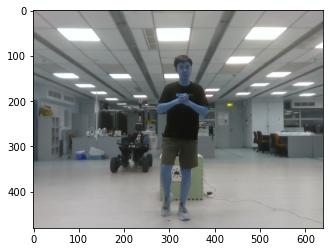

In [48]:
# print(rgb_data[0,:,:,:].shape)
# import torchvision
# from torchvision.transforms import InterpolationMode
# resized_img = torchvision.transforms.functional.resize(rgb_data[0,:,:,:], (480,480), interpolation=InterpolationMode.BILINEAR)
# print(resized_img.shape)
# show_image(rgb_data[0,:,:,:].permute(1,2,0).detach().cpu())
imgplot = plt.imshow(np.int16(rgb_data[0,:,:,:].permute(1,2,0).detach().cpu().numpy()))

plt.show()
# show_image(resized_img.detach().cpu())

In [ ]:
def show_image2(image1, image2, alpha=0.8):
    img1 = np.asarray(image1)
    img2 = np.asarray(image2)
    plt.figure(figsize=(16, 16))
    plt.imshow(img1)
    plt.imshow(img2, alpha=alpha)
    plt.axis('off')
    plt.show()

show_image2(rgb_data[0,:,:,:], cross_modal_embedding_4_sample.detach().cpu())